In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

import sys
sys.path.append('../')

from src.SlovotvirModel import run_model_parallel

from src.helpers import letter_subplots

import numpy as np 

import pickle

sns.set(context='paper', 
        style='ticks', 
        font_scale=1.2,
        rc={'axes.spines.right': False, 
            'axes.spines.top': False,})

/opt/homebrew/lib/python3.11/site-packages/bayesflow/trainers.py:27: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [19]:
# unpickle data/post_samples_final_0306.pkl
with open('../data/post_samples_final_2012.pkl', 'rb') as f:
    post_samples = pickle.load(f)

In [20]:
# unpickle prior draws
with open('../data/prior_draws.pkl', 'rb') as f:
    prior_draws = pickle.load(f)

In [21]:
true_likes = pickle.load(open("../data/true_likes.pkl", "rb"))
true_likes_lengths = pickle.load(open("../data/true_len_likes.pkl", "rb"))

In [22]:
# divide true_likes_lengths into likes and lengths
# true_likes = [x[1] for x in true_likes_lengths]
true_lengths = [x[0] for x in true_likes_lengths]

In [23]:
priors = [np.random.uniform(-5, 1, 50000), 
          np.random.uniform(-2, 2, 50000),
          np.random.lognormal(0, 0.5, 50000),]

param_names = ['Length bias (α)', 
               'Frequency bias (β)', 
               'Exploration bias (τ)']

post_hdi = az.hdi(post_samples, hdi_prob=0.95)

null = [0, 1, 1]

/var/folders/1c/pphtjl397rnbdcp94xmwzkqr0000gn/T/ipykernel_25655/2009658165.py:9: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  post_hdi = az.hdi(post_samples, hdi_prob=0.95)


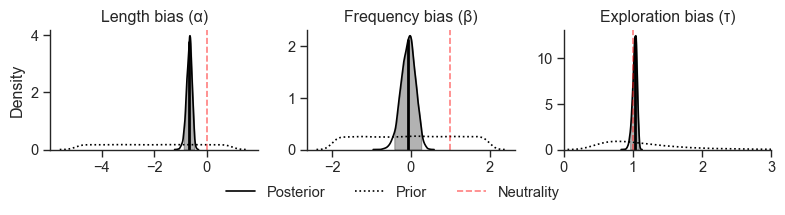

In [41]:
fig, ax = plt.subplots(1, 3, figsize=(8, 2))

for i in range(3):
    x_values, y_values = sns.kdeplot(post_samples[:, i], 
                                     ax=ax[i], 
                                     color='black',
                                     common_norm=True,
                                     label='Posterior').lines[0].get_data()
    y_values /= np.trapz(y_values, x_values)
    ax[i].fill_between(x_values, y_values, 
                       where=(x_values >= post_hdi[i][0]) & 
                        (x_values <= post_hdi[i][1]), 
                        color='black', alpha=0.3)
    
    sns.kdeplot(priors[i], ax=ax[i], 
                color='black', 
                linestyle='dotted',
                common_norm=True,
                label='Prior')
    
    # Add mean line for posterior
    posterior_mean = np.mean(post_samples[:, i])
    mean_density = np.interp(posterior_mean, x_values, y_values)
    ax[i].plot([posterior_mean, posterior_mean], [0, mean_density], 
               color='black', linestyle='solid', alpha=1, linewidth=2)

    ax[i].set_title(param_names[i])
    ax[i].axvline(null[i], 
                  color='red', 
                  linestyle='dashed',
                  alpha=0.5,
                  label='Neutrality')
    if i == 0:
        ax[i].set_ylabel('Density')
    elif i == 2:
        ax[i].set_xlim(0, 3)
        ax[i].set_ylabel('')
    else:
        ax[i].set_ylabel('')
    
handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, 
           loc='lower center', ncol=3,
           frameon=False, bbox_to_anchor=(0.5, -0.1))

plt.tight_layout()
# save figure
plt.savefig('../figures/posteriors_final.pdf',
            dpi=300, 
            bbox_inches='tight')
plt.show()

In [26]:
posterior_predictive = run_model_parallel(np.random.choice(post_samples[:, 0], 100), 
                                          np.random.choice(post_samples[:, 1], 100), 
                                          np.random.choice(post_samples[:, 2], 100), 100)

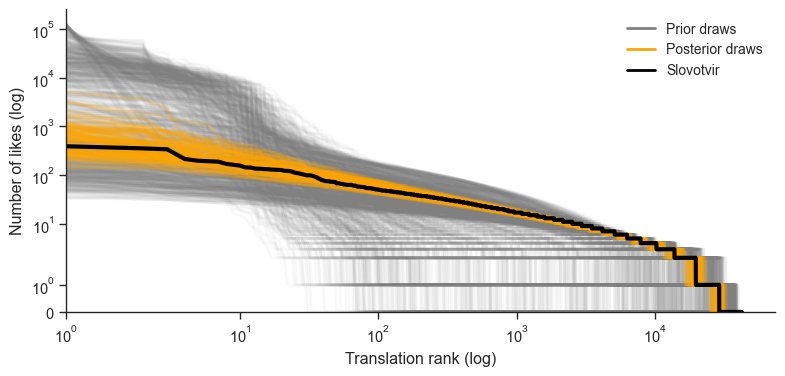

In [27]:
plt.figure(figsize=(8, 4))  # Increased height to fit the plot

# First plot with log x-scale
ax1 = plt.subplot(1, 1, 1)

# Plot prior draws with label
for i, d in enumerate(prior_draws):
    label = 'Prior draws' if i == 0 else None
    ax1.plot(range(1, len(d) + 1), d, 
             color='grey', 
             alpha=0.05, 
             linewidth=2,
             label=label)

# Plot parameter estimates with label
for i, _ in enumerate(posterior_predictive):
    label = 'Posterior draws' if i == 0 else None
    ax1.plot(range(1, len(_[0]) + 1), _[0], 
             color='orange', 
             alpha=0.25, 
             linewidth=2,
             label=label)

ax1.plot(range(1, len(true_likes) + 1), 
         true_likes, 
         label='Slovotvir', 
         color='black', 
         linewidth=3, 
         alpha=1)

ax1.set_xscale('symlog', base=10)
ax1.set_yscale("symlog", base=10)
ax1.set_xlabel('Translation rank (log)')
ax1.set_ylabel('Number of likes (log)')
ax1.set_ylim(0, None)
ax1.set_xlim(1, None)

sns.despine()

# Adjust layout to make room for the legend at the bottom
plt.tight_layout()
plt.subplots_adjust(bottom=0.2)

# Create a legend and place it at the bottom
handles, labels = ax1.get_legend_handles_labels()
legend = plt.legend(handles, labels, 
                    frameon=False, 
                    ncol=1,
                    fontsize=10)
for legend_line in legend.get_lines():
    legend_line.set_alpha(1.0)
    legend_line.set_linewidth(2)

plt.show()

In [28]:
N = 100

# length_bias_ = run_model_parallel([-2] * N, 
#                                   np.random.choice(post_samples[:, 1], N), 
#                                   np.random.choice(post_samples[:, 2], N), 
#                                   N)
neutral_ = run_model_parallel([0] * N, 
                              np.random.choice(post_samples[:, 1], N), 
                              np.random.choice(post_samples[:, 2], N), 
                              N)

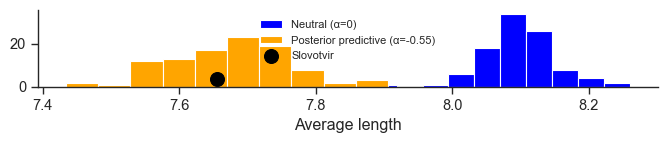

In [29]:
plt.figure(figsize=(8, 1))

plt.hist([sum(y) / sum(x) for x, y in neutral_], 
         bins=10,
         label='Neutral (α=0)', 
         color='blue', 
         alpha=1, 
         density=False,)
plt.hist([sum(y) / sum(x) for x, y in posterior_predictive], 
         bins=10,
         label='Posterior predictive (α=-0.55)', 
         color='orange', 
         alpha=1, 
         density=False)
# plt.scatter(np.mean([sum(y) / sum(x) for x, y in posterior_predictive]), 
#             3.5, color='black', s=100, label='Slovotvir')

true_avg_length = sum(true_lengths * true_likes) / sum(true_likes)

plt.scatter(true_avg_length, 
            3.5, color='black', s=100, label='Slovotvir')

plt.xlabel('Average length')

plt.legend(frameon=False, 
           ncol=1, 
        #    bbox_to_anchor=(0.5, -1),
           #text size
           fontsize=8)
sns.despine()
plt.show()

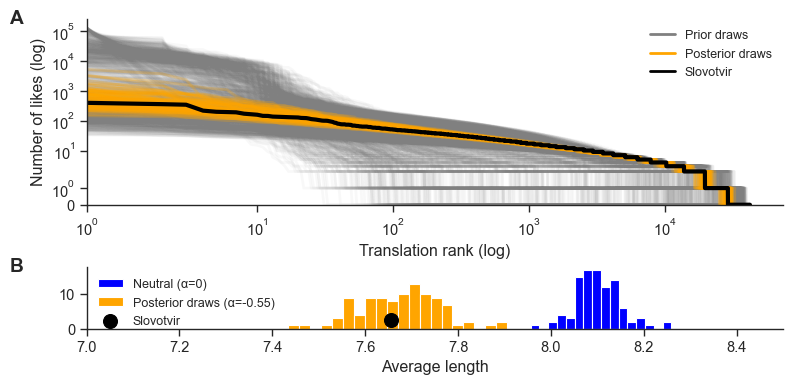

In [42]:
fig, axes = plt.subplots(2, 1, figsize=(8, 4), gridspec_kw={'height_ratios': [3, 1]})

letter_subplots()

# First plot with log x-scale
ax1 = axes[0]

# Plot prior draws with label
for i, d in enumerate(prior_draws):
    label = 'Prior draws' if i == 0 else None
    ax1.plot(range(1, len(d) + 1), d, 
             color='grey', 
             alpha=0.05, 
             linewidth=2,
             label=label)

# Plot parameter estimates with label
for i, _ in enumerate(posterior_predictive):
    label = 'Posterior draws' if i == 0 else None
    ax1.plot(range(1, len(_[0]) + 1), _[0], 
             color='orange', 
             alpha=0.25, 
             linewidth=2,
             label=label)

ax1.plot(range(1, len(true_likes) + 1), 
         true_likes, 
         label='Slovotvir', 
         color='black', 
         linewidth=3, 
         alpha=1)

ax1.set_xscale('symlog', base=10)
ax1.set_yscale("symlog", base=10)
ax1.set_xlabel('Translation rank (log)')
ax1.set_ylabel('Number of likes (log)')
ax1.set_ylim(0, None)
ax1.set_xlim(1, None)
ax1.set_rasterized(True)

sns.despine(ax=ax1)

# Create a legend and place it at the bottom
handles, labels = ax1.get_legend_handles_labels()
legend = ax1.legend(handles, labels, 
                    frameon=False, 
                    ncol=1,
                    fontsize=9)
for legend_line in legend.get_lines():
    legend_line.set_alpha(1.0)
    legend_line.set_linewidth(2)

# Second plot: Histogram
ax2 = axes[1]

ax2.hist([sum(y) / sum(x) for x, y in neutral_], 
         bins=20,
         label='Neutral (\u03b1=0)', 
         color='blue', 
         alpha=1, 
         density=False)
ax2.hist([sum(y) / sum(x) for x, y in posterior_predictive], 
         bins=20,
         label='Posterior draws (\u03b1=-0.55)', 
         color='orange', 
         alpha=1, 
         density=False)

true_avg_length = sum(true_lengths * true_likes) / sum(true_likes)
ax2.scatter(true_avg_length, 
            2.5, color='black', s=100, label='Slovotvir')
ax2.set_xlabel('Average length')
ax2.set_xlim(7, 8.5)
ax2.legend(frameon=False, 
           ncol=1, 
           fontsize=9,
           loc='upper left')
sns.despine(ax=ax2)

# Adjust layout to make everything fit nicely
plt.tight_layout()
plt.subplots_adjust(hspace=0.5)

plt.savefig('../figures/posterior_check.pdf',
            dpi=300, 
            bbox_inches='tight')

plt.show()

In [32]:
print(round(np.mean([sum(y) / sum(x) for x, y in posterior_predictive]), 2))

7.68


In [33]:
print(round(true_avg_length, 2))

7.66


In [34]:
print(round(np.mean([sum(y) / sum(x) for x, y in neutral_]), 2))

8.1


In [402]:
x = np.arange(0, 100, 1).astype(float)

/var/folders/1c/pphtjl397rnbdcp94xmwzkqr0000gn/T/ipykernel_4255/2656064877.py:21: RuntimeWarning: divide by zero encountered in reciprocal
  axs[2].plot(x, x ** -1,


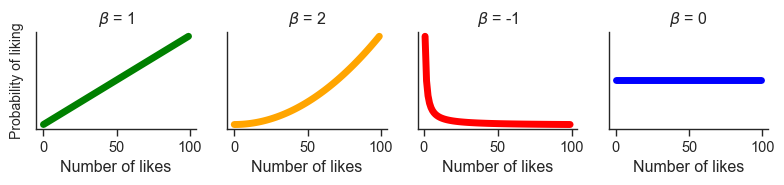

In [403]:
fig, axs = plt.subplots(1, 4, figsize=(8, 2))


axs[0].plot(x, x ** 1, 
            linewidth=5, color='green')
axs[0].set_yticks([])
axs[0].set_title(r'$\beta$ = 1')
# set ylabels
axs[0].set_ylabel('Probability of liking', fontsize=10)
# xlabel
axs[0].set_xlabel('Number of likes')

axs[1].plot(x, x ** 2, 
            linewidth=5, color='orange')
axs[1].set_yticks([])
axs[1].set_title(r'$\beta$ = 2')
axs[1].set_ylabel('')
# xlabel
axs[1].set_xlabel('Number of likes')

axs[2].plot(x, x ** -1, 
            linewidth=5, color='red')
axs[2].set_yticks([])
axs[2].set_title(r'$\beta$ = -1')
axs[2].set_ylabel('')
# xlabel
axs[2].set_xlabel('Number of likes')

axs[3].plot(x, x ** 0, 
            linewidth=5, 
            color='blue')
axs[3].set_yticks([])
axs[3].set_title(r'$\beta$ = 0')
axs[3].set_ylabel('')
# xlabel
axs[3].set_xlabel('Number of likes')

plt.tight_layout()
plt.show()


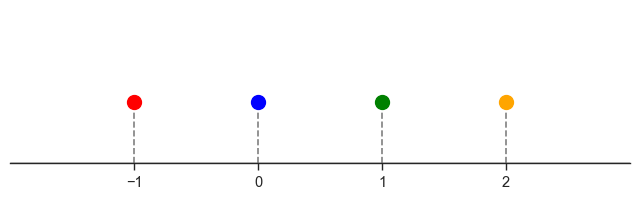

In [404]:
# Create the figure and axis
fig, ax = plt.subplots(1, 1, figsize=(8, 2))

# Draw the number line
ax.axhline(0, color='black', linewidth=1)

points = [-1, 0, 1, 2]
colors = ['red', 'blue', 'green', 'orange']

# Set up the number line
ax.set_yticks([])
ax.set_xticks(points)
ax.set_xlim(-2, 3)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_position(('data', 0))

# add lines connecting points to number line
for point, color in zip(points, colors):
    ax.plot([point, point], [0, 0.019], 
            color='grey', linestyle='dashed')

# Plot points slightly above the number line
for point, color in zip(points, colors):
    ax.plot(point, 0.02, 'o', 
            color=color, markersize=10)  # Adjust y-coordinate to 0.1


plt.ylim(0, 0.05)

plt.show()


In [476]:
def model(s, t, sigma, mu):

    pops = []

    pop = np.random.binomial(1, 0.5, s)

    for _ in range(t):
        # count the number of 1s and 0s
        counts = np.bincount(pop, minlength=2).astype(float)
        p = counts ** sigma
        p = p / p.sum()
        p = np.nan_to_num(p)
        pop = np.random.binomial(1, p[1], s)
        # add mutation n% of the pop should mutate
        pop[np.random.choice(s, int(s * mu))] = np.random.binomial(1, 0.5, int(s * mu))
        pops.append(pop.mean())

    return pops

In [489]:
r = [model(1000, 50, 2, 0.05) for _ in range(100)]

(0.0, 1.0)

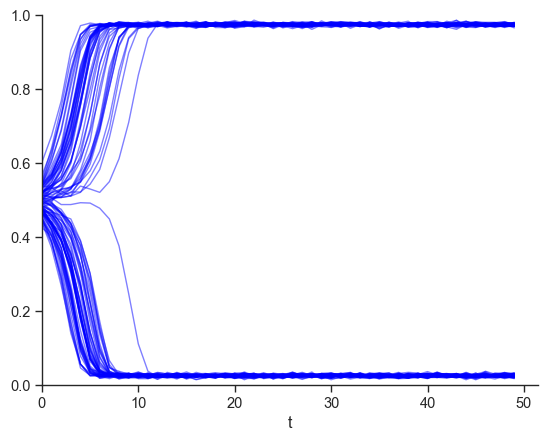

In [490]:
for i in r:
    plt.plot(i, 
             alpha=0.5, 
             color='blue',
             linewidth=1,)
plt.xlim(0, None)
plt.xlabel('t')
plt.ylim(0, 1)